<h1 style="font-size:300%;"> Predicting World Movie Box Office Sales Using KNN Regression </h1>

<h2> Introduction </h2>

In the film industry, sales projections are important because they help production companies determine the financial risk associated with a project and predict profits (Galvão & Henriques, 2018). Our project will use a K-nearest neighbors regression model to predict the world sales for a movie given its genres, runtime, distributor, and license. To answer this question, we will be exploring a [data set containing the 1000 highest grossing movies in Hollywood](https://www.kaggle.com/sanjeetsinghnaik/top-1000-highest-grossing-movies).   

The columns in this dataset are:
<ul>
    <li> Title: movie title </li>
    <li> Movie Info: short description of the movie </li>
    <li> Distributor: company responsible for marketing and distributing content to the public </li>
    <li> Release Date: the date when the movie was released </li>
    <li> Domestic Sales (USD) </li>
    <li> International Sales (USD) </li>
    <li> World Sales (USD) </li>
    <li> Genre: The category of film that defines a film based on its stylistic, narrative or thematic elements </li>
    <li> Movie Runtime: length of movie (..hr..min) </li>
    <li> License: determines how accessible the movie is to the public, which includes general admission (G), parental guidance advised (PG), parental guidance strongly advised (PG-13), and restricted (R)
</ul>  

## Preliminary Exploratory Data Analysis

In [28]:
# set up
library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
library(gridExtra)
options(repr.matrix.max.rows = 6)
set.seed(22)

#### Reading, Cleaning, and Wrangling Data

Before starting the project, we set a seed to ensure that our randomization would be reproducible, so that it will produce consistent results. 

The untidy dataset was read into the notebook from kaggle. To tidy our dataset, we first removed the white spaces in the column headers by replacing the spaces with periods. This allowed us to reference these column names as objects in functions used in data analysis.  

In [2]:
# reading in data
url <- "https://raw.githubusercontent.com/karlie-tr/dataset/main/Highest%20Holywood%20Grossing%20Movies.csv"
download.file(url, destfile = "highest-hollywood-grossing-movies.csv")
movies_data <- read_csv("highest-hollywood-grossing-movies.csv")

# remove white space in headers
colnames(movies_data) <- make.names(colnames(movies_data))
movies_data

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Title = col_character(),
  `Movie Info` = col_character(),
  Distributor = col_character(),
  `Release Date` = col_character(),
  `Domestic Sales (in $)` = col_double(),
  `International Sales (in $)` = col_double(),
  `World Sales (in $)` = col_double(),
  Genre = col_character(),
  `Movie Runtime` = col_character(),
  License = col_character()
)



X1,Title,Movie.Info,Distributor,Release.Date,Domestic.Sales..in...,International.Sales..in...,World.Sales..in...,Genre,Movie.Runtime,License
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0,Star Wars: Episode VII - The Force Awakens (2015),"As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace.",Walt Disney Studios Motion Pictures,"December 16, 2015",936662225,1132859475,2069521700,"['Action', 'Adventure', 'Sci-Fi']",2 hr 18 min,PG-13
1,Avengers: Endgame (2019),"After the devastating events of Avengers: Infinity War, the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe.",Walt Disney Studios Motion Pictures,"April 24, 2019",858373000,1939128328,2797501328,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",3 hr 1 min,PG-13
2,Avatar (2009),A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home.,Twentieth Century Fox,"December 16, 2009",760507625,2086738578,2847246203,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",2 hr 42 min,PG-13
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
915,Eat Pray Love (2010),"A married woman realizes how unhappy her marriage really is, and that her life needs to go in a different direction. After a painful divorce, she takes off on a round-the-world journey to ""find herself"".",Sony Pictures Entertainment (SPE),"August 13, 2010",80574010,124020006,204594016,"['Biography', 'Drama', 'Romance']",2 hr 13 min,PG-13
916,The Texas Chainsaw Massacre (2003),"After picking up a traumatized young hitchhiker, five friends find themselves stalked and hunted by a deformed chainsaw-wielding loon and his family of equally psychopathic killers.",New Line Cinema,"October 17, 2003",80571655,26792250,107363905,"['Crime', 'Horror']",1 hr 38 min,R
917,Zookeeper (2011),"A group of zoo animals decide to break their code of silence in order to help their lovable zookeeper find love, without opting to leave his current job for something more illustrious.",Sony Pictures Entertainment (SPE),"July 6, 2011",80360843,89491916,169852759,"['Comedy', 'Family', 'Fantasy', 'Romance']",1 hr 42 min,PG


*Table 1*: Original Data

\
We chose to predict world sales because it is the most holistic measure of sales and encompasses both domestic and international sales. As such, it does not make sense to use the other two sales variables as predictors since they directly determine world sales.

We selected the columns required to filter the dataset (release date), the variable we wanted to predict (world sales), and the variables we wanted to explore as predictors (distributor, release date, sales, genre, runtime and license). Once these variables were selected, we changed the column names for easier referencing and removed all the white space in the dataset to help filter observations in future analysis. 

Our project aims to create a regression model that can accurately predict sales of new movies. We chose to only consider recent films so that our model reflects current trends. To do so, we separated the year from the release date column and the movie title and then filtered for films released since 2010. The release date will not be used as a predictor since we want to be able to predict sales for future movies.

In [3]:
# remove unusable columns
vars <- c("Title", "Distributor","Release.Date","World.Sales..in...","Genre","Movie.Runtime","License") # vars that we want to keep
movies_data_filtered <- movies_data %>%
                        select(all_of(vars))

# change column name
colnames(movies_data_filtered) <- c("Title","Distributor","Release_Date","World_Sales","Genre","Runtime","License")

# remove all white space in dataframe
movies_data_no_space <- as.data.frame(apply(movies_data_filtered, 2, str_remove_all, " "))

# separate release year from Release_Date
movies_release_date <- separate(movies_data_no_space,
                            col = Release_Date,
                            into = c("date", "Release_Year"),
                            sep = ","
                           )

# separate release year from movie title
movies_release_date <- separate(movies_release_date,
                            col = Title,
                            into = c("Title", "year"),
                            sep = "[()]"
                           )

# filter for movies released since 2010
movies_2010 <- movies_release_date %>%
                    select(-date, -year) %>%
                    filter(Release_Year >= 2010)
      

#movies_2010                 

Warning message:
“Expected 2 pieces. Additional pieces discarded in 918 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


The original data frame reported the time in hours and minutes as a character string, but we needed the time to be a numerical value to reflect the fact that it is a continuous variable. To tidy this column, we created a new variable containing the total duration in minutes and merged the new column with the tidy dataframe. At this point, we also converted our categorical variables to factors.

In [4]:
# tidying Runtime column
movies_2010_separate_runtime <- separate(movies_2010,
                                            col = Runtime,
                                            into = c("Runtime_hr", "Runtime_min"),
                                            sep = "hr"
                                         )
# remove min from Runtime_min
movies_2010_separate_minute <- separate(movies_2010_separate_runtime,
                                        col = Runtime_min,
                                        into = c("Runtime_min"),
                                        sep = "min"
                                       )

# change hr and time into duration (minutes)
numeric_duration <- movies_2010_separate_minute %>%
                    select(Runtime_hr, Runtime_min) %>%
                    as.data.frame() %>%
                    mutate(Runtime_hr = as.numeric(Runtime_hr)) %>%
                    mutate(Runtime_min = as.numeric(Runtime_min)) %>%
                    mutate(Duration = Runtime_hr * 60 + Runtime_min, na.rm =TRUE) %>%
                    select(Duration)

# Merge Duration (runtime in minutes) with movies_2010 and convert character columns to factors
movies_2010_tidy <- movies_2010 %>%
                    select(-Runtime,-Title, -Release_Year) %>%
                    cbind(numeric_duration) %>%                                 # bind the new column into the df
                    mutate(World_Sales = as.numeric(World_Sales),
                           Distributor = as.factor(Distributor),
                           License = as.factor(License)) %>%
                    na.omit()

#movies_2010_tidy



Warning message:
“Expected 1 pieces. Additional pieces discarded in 352 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


The original genre column was a character string containing a list of genres the movie belongs to. Given that each movie could belong to more than one genre, we decided to tidy this data by creating a separate binary column for each genre. Converting it to binary also made the data numerical, making it easier to use as a predictor in the regression model.

In [5]:
# tidying genre data

# creating list of included genres
genre_list <- movies_2010_tidy %>%
    select(Genre) %>%
    # remove brackets, quotation marks, and spaces from string
    mutate(Genre = str_replace_all(string = Genre, pattern = regex("[]\\[\' ]"), replacement = "")) %>% 
    # change string into list
    mutate(Genre = as.list(strsplit(Genre, ","))) %>%
    # make a list of all unique values
    pull() %>%
    flatten() %>%
    unique()

# creating columns for each genre
movies_genres <- movies_2010_tidy
for(i in genre_list)
  { 
    movies_genres <- movies_genres %>%
        mutate(!!i := str_detect(Genre, i))
}

#movies_genres


movies_tidy <- select(movies_genres, -Genre) %>%
    mutate(across(Action:Documentary, as.numeric)) %>%
    as_tibble()
#glimpse(movies_tidy)
movies_tidy

Distributor,World_Sales,License,Duration,Action,Adventure,Sci-Fi,Drama,Fantasy,Animation,⋯,Thriller,War,Biography,Mystery,Horror,Music,Sport,History,Western,Documentary
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WaltDisneyStudiosMotionPictures,2069521700,PG-13,138,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WaltDisneyStudiosMotionPictures,2797501328,PG-13,181,1,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
UniversalPictures,1670516444,PG-13,124,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
UniversalPictures,215863606,R,115,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SonyPicturesEntertainment(SPE),204594016,PG-13,133,0,0,0,1,0,0,⋯,0,0,1,0,0,0,0,0,0,0
SonyPicturesEntertainment(SPE),169852759,PG,102,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


*Table 2*: Tidy Data

\
We split our tidied data into 75% training and 25% testing data, stratifying based on sales. This is important because we needed the testing set to assess whether our model can be applied to unseen data, such as a new movie. This ratio of training/testing data was chosen because it is a good compromise that provides enough data for model training and enough testing data to assess its accuracy.

In [6]:
# split data into training and testing set
movies_split <- initial_split(movies_tidy, prop = 0.75, strata = World_Sales)
movies_train <- training(movies_split)
movies_test <- testing(movies_split)

#### Exploratory Data Analysis on Training Data

Once we had a tidy dataset, we needed to decide which predictors to include in our final regression model. To help us decide, we used the training dataset to explore the relationships between movie sales and each predictor.

We first created a summary table for world sales to visualize the average and overall range of sales in our data set. We then created a histogram to determine how the sales were distributed. 

In [7]:
# table showing distributors within the top grossing movies released since 2010

movies_summary <- movies_train %>%
    summarise(mean = mean(World_Sales),
             median = median(World_Sales),
             standard_deviation = sd(World_Sales),
             min = min(World_Sales),
             max = max(World_Sales))

movies_summary

mean,median,standard_deviation,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
463167251,357537980,324367711,86086881,2069521700


*Table 3*: Summary of World Sales

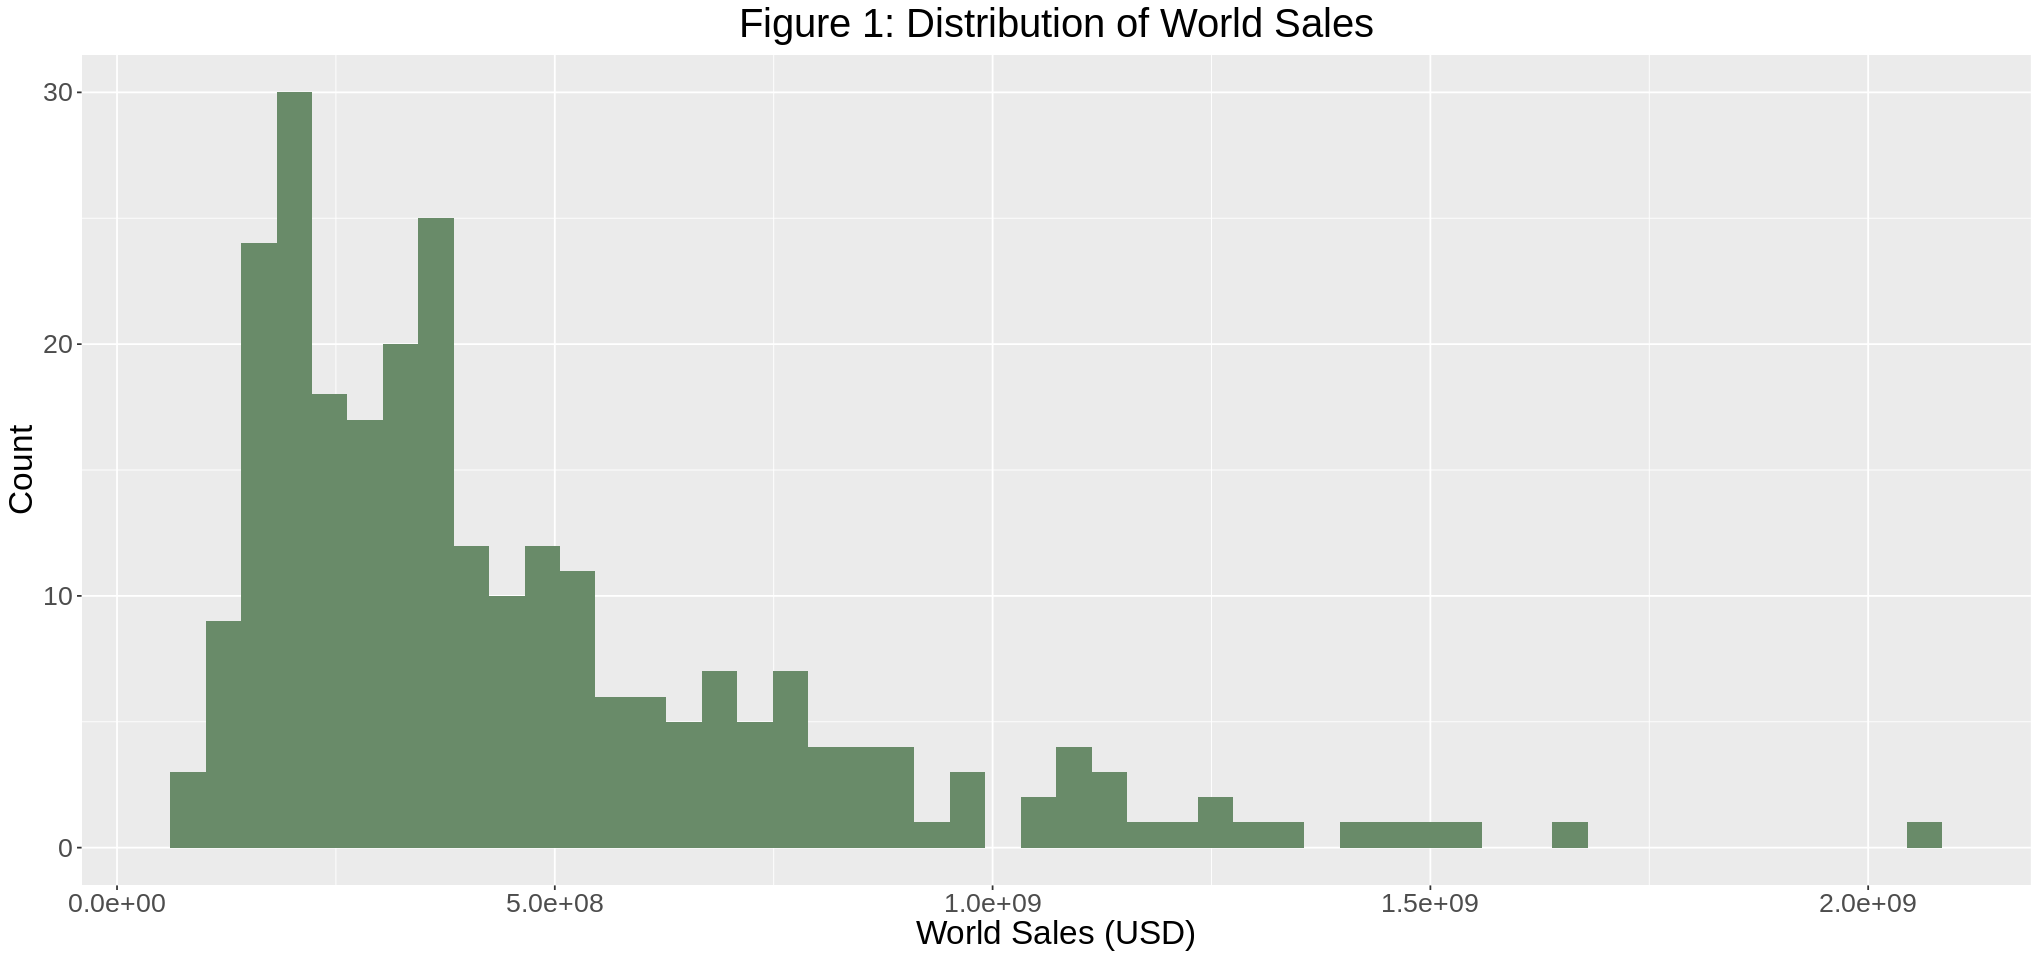

In [8]:
movies_histogram <- movies_train %>%
    ggplot(aes(x = World_Sales)) +
        geom_histogram(fill = "darkseagreen4", bins = 50) +
        xlab("World Sales (USD)") +
        ylab("Count") +
        ggtitle("Figure 1: Distribution of World Sales") +
        theme(text = element_text(size = 20),                        
                                  plot.title = element_text(hjust = 0.5))
        

options(repr.plot.width = 17, repr.plot.height = 8)
movies_histogram

In [9]:
license_estimates <- movies_train %>%
                        group_by(License) %>%
                        summarize(movies_released = n(),
                                  mean_world_sales = mean(World_Sales))

movies_by_license_plot <- license_estimates %>%
                            ggplot(aes(x = License, 
                                       y = movies_released)) + 
                            geom_bar(stat = "identity", fill = "darkseagreen4") +
                            xlab("License") +
                            ylab("Number of movies") +
                            theme(text = element_text(size = 15),
                                  legend.position = "none",                        
                                  plot.title = element_text(hjust = 0.5)) +
                            ggtitle("Figure 2: Movies Released by License") 

sales_by_license_plot <- license_estimates %>%
                            ggplot(aes(x = License, 
                                       y = mean_world_sales)) + 
                            geom_bar(stat = "identity", fill = "darkseagreen4") +
                            xlab("License") +
                            ylab("Average Sales (USD)") +
                            theme(text = element_text(size = 15),
                                  legend.position = "none",                        
                                  plot.title = element_text(hjust = 0.5)) +
                            ggtitle("Figure 3: Average Sales by License")

`summarise()` ungrouping output (override with `.groups` argument)



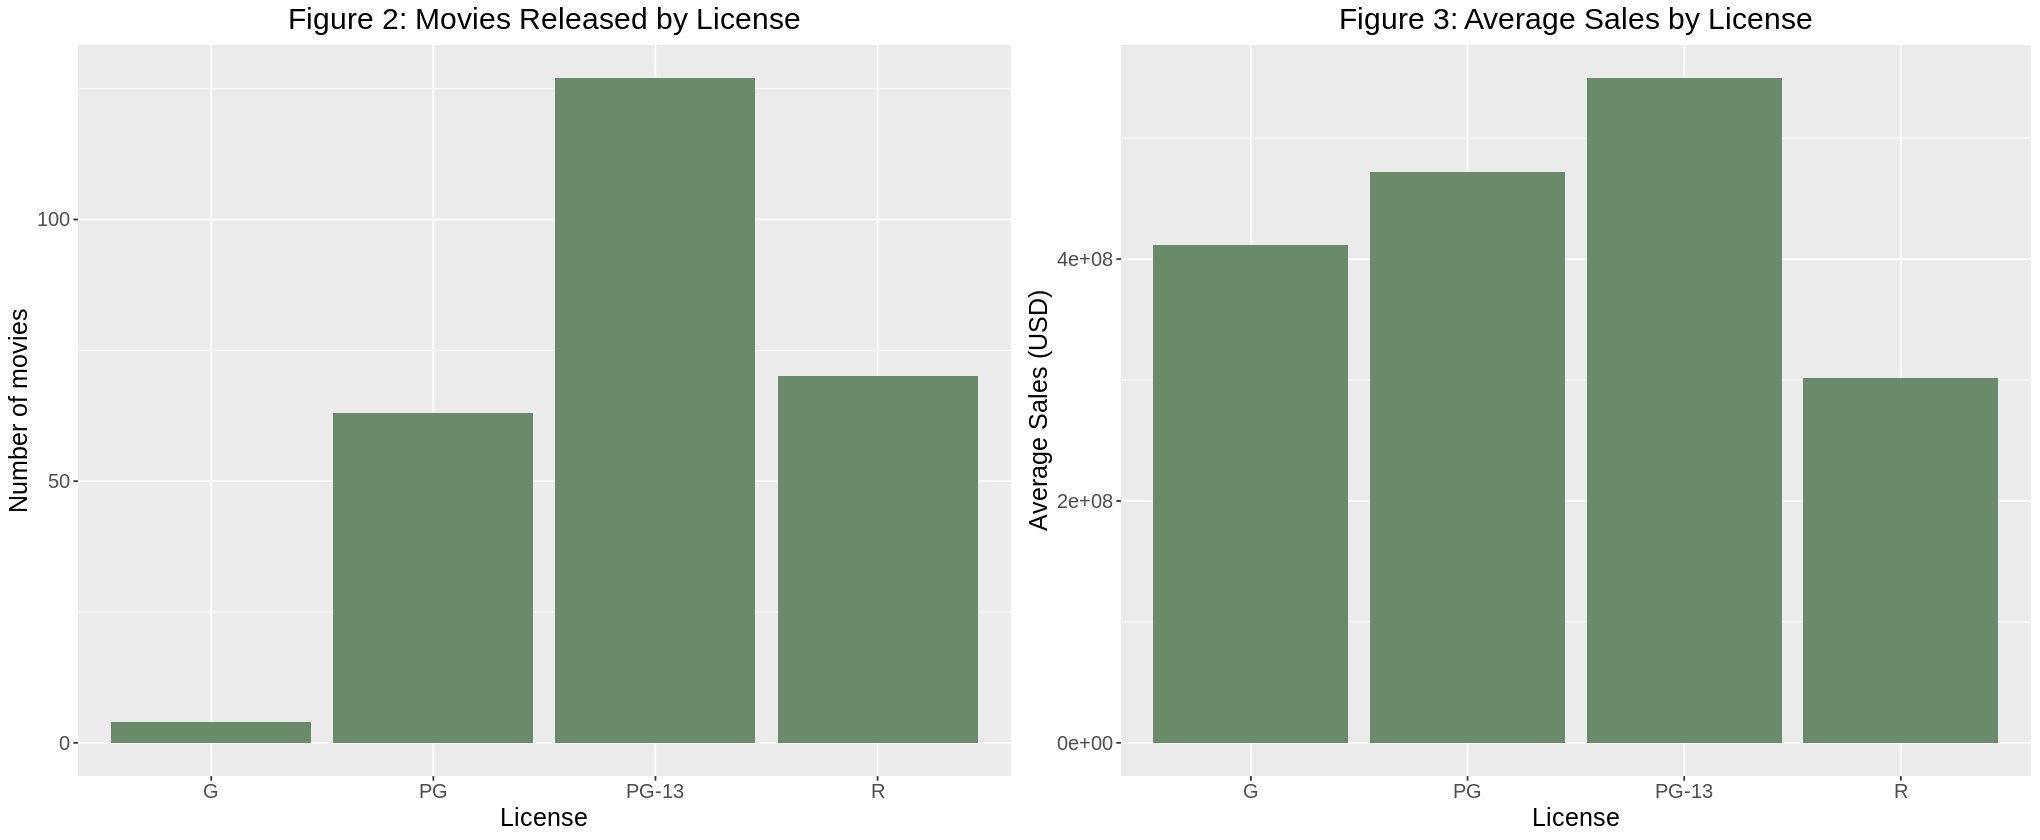

In [10]:
options(repr.plot.width = 17, repr.plot.height = 7)

grid.arrange(movies_by_license_plot, sales_by_license_plot, ncol = 2)  # plot 2 graph side-by-side for comparison

To explore the relationship between each categorical predictor and world sales, we looked at the number of top grossing movies for each factor and their average sales using bar plots. 

Figure 2 was included to visualize the distribution of our data, as this can affect our KNN-regression. In Figure 3, world sales are shown to vary according to license, with PG-13 movies having the highest average sales and R-rated movies having the lowest. Hence, we hypothesized that license influences world sales and decided to include this variable in our regression model as a predictor. 

In [11]:
# visualization of movie distributors and movie sales

distributor_estimates <- movies_train %>%
                                group_by(Distributor) %>%
                                summarize(movies_released = n(),
                                          mean_world_sales = mean(World_Sales))

# plot number of movies by distributor
movies_by_distributor_plot <- distributor_estimates %>%
                                ggplot(aes(x = reorder(Distributor, movies_released), 
                                           y = movies_released)) + 
                                geom_bar(stat = "identity", fill = "darkseagreen4") +
                                xlab("Distributor") +
                                ylab("Number of movies") +
                                theme(text = element_text(size = 15),
                                      legend.position = "none",                        
                                      plot.title = element_text(hjust = 0.5)) +
                                ggtitle("Figure 4: Movies Released by Distributor") +
                                coord_flip()

# plot mean world sales by distributor
distributor_sales_plot <- distributor_estimates %>%
                            ggplot(aes(x = reorder(Distributor, mean_world_sales), 
                                       y = mean_world_sales)) + 
                            geom_bar(stat = "identity", fill = "darkseagreen4")  +
                            xlab("Distributor") +
                            ylab("Average World Sales (USD)") +
                            labs(fill = "Distributor") +
                            theme(text = element_text(size = 15),
                                  legend.position = "none",   
                                  plot.title = element_text(hjust = 0.5)) +
                            ggtitle("Figure 5: Average World Sales by Distributor") +
                            coord_flip()

`summarise()` ungrouping output (override with `.groups` argument)



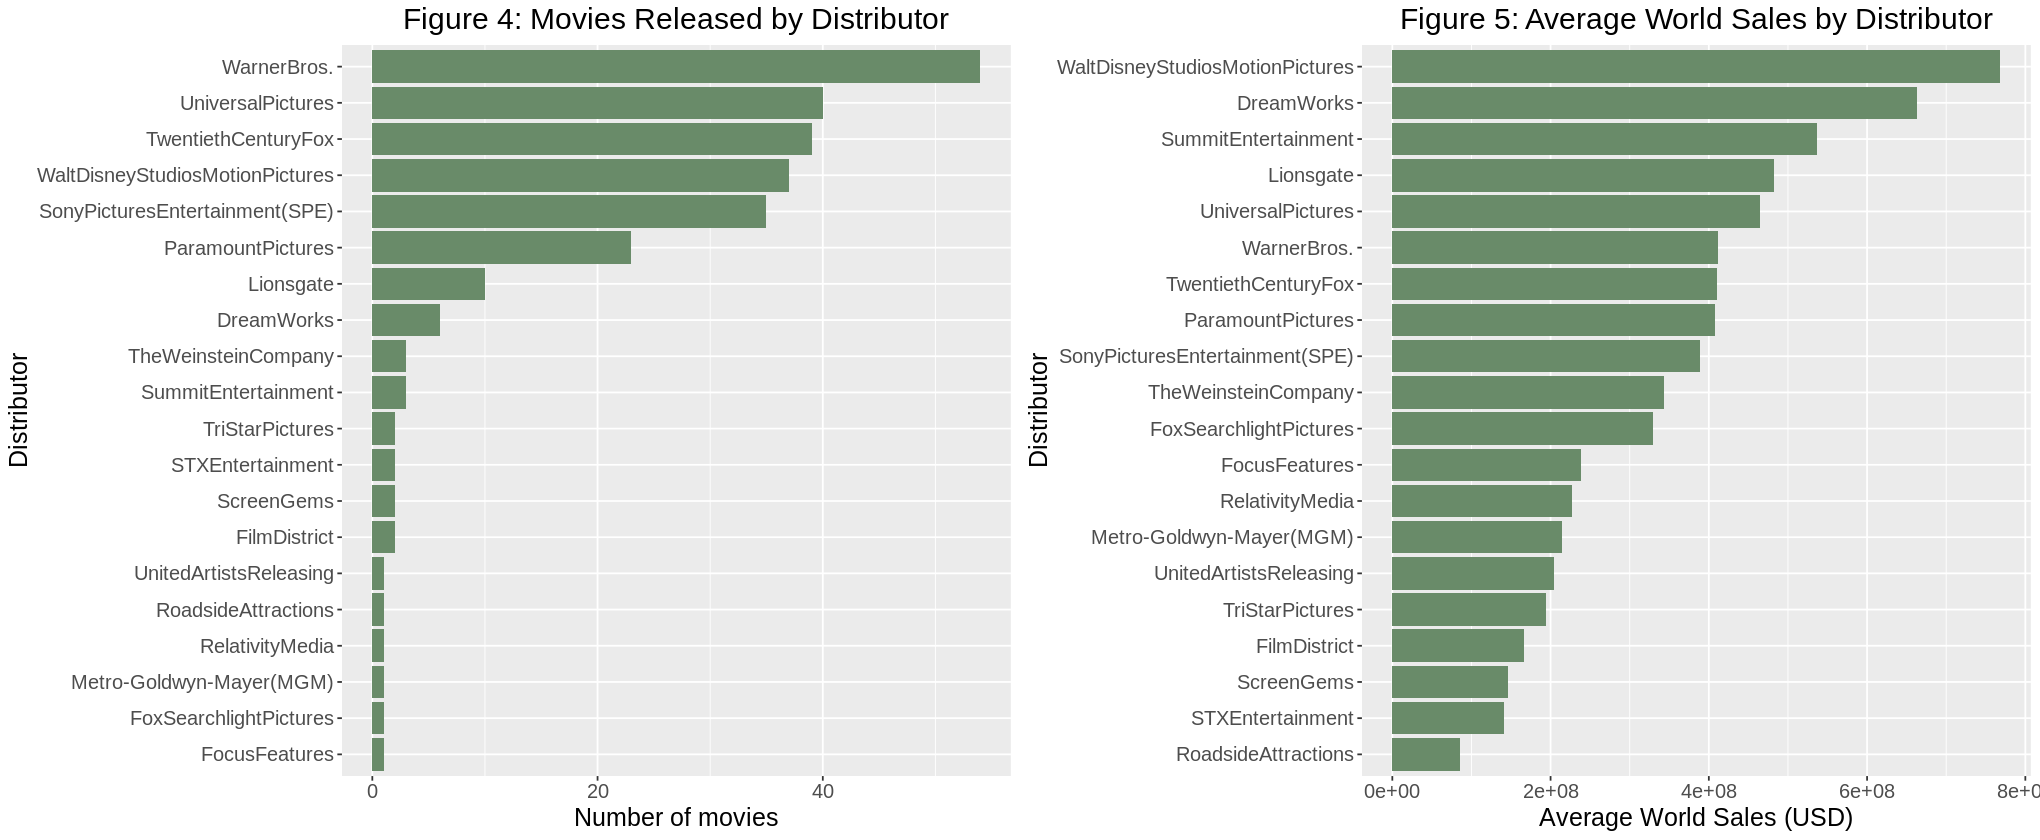

In [12]:
 # plot 2 graph side-by-side for comparison
options(repr.plot.width = 17, repr.plot.height = 7)

grid.arrange(movies_by_distributor_plot, distributor_sales_plot, ncol = 2) 

We then visualized the distribution in Figure 4 to see which companies were most frequent in our data set. Since Figure 5 shows that average sales vary between distributors, we decided to include this variable in our regression model. 

In [30]:
# calculate the average world sales of each genre

# define dataframe with only World_Sales and Genre columns
sales_by_genre_df <- movies_train %>%
                        select(World_Sales,Action:Documentary)

# calculate total sales of each genre
total_sales_by_genre <- sales_by_genre_df %>% 
                          mutate(across(Action:Documentary, ~ .x* World_Sales, .names = "{.col}")) %>% # multiply World_Sales by genre 
                          select(-World_Sales) %>%
                          bind_rows(purrr::map_dbl(.,sum)) %>%                                         # calculate the total sales by genre
                          tail(1) %>%
                          pivot_longer(cols = Action:Documentary,                                      # tidy the dataframe
                                       names_to = "genre",
                                       values_to = "total_sales")

# calculate number of movies in each genre
total_movies_by_genre <- sales_by_genre_df %>%
                            select(-World_Sales) %>%
                            bind_rows(purrr::map_dbl(.,sum)) %>%                                      # calculate number of movies by genre
                            tail(1) %>%
                            pivot_longer(cols = Action:Documentary,                                   # tidy the dataframe
                                         names_to = "genre",
                                         values_to = "total_movies")
# calculate average sales
avg_sales_by_genre <- merge(total_sales_by_genre, total_movies_by_genre) %>%
                                mutate(average_sales = total_sales/total_movies)                     

# plot total number of movies by genre
total_movies_by_genre_plot <- total_movies_by_genre %>%
                                    ggplot(aes(x = reorder(genre, total_movies),
                                               y = total_movies)) +
                                    geom_bar(stat = "identity", fill = "darkseagreen4") +
                                    labs(x = "Genre",
                                         y = "Number of Movies") +
                                    theme(text = element_text(size = 15),
                                          legend.position = "none",   
                                          plot.title = element_text(hjust = 0.5)) +
                                    ggtitle("Figure 6: Number of Movies by Genre") +
                                    coord_flip()

# plot average world sales by genre
avg_sales_by_genre_plot <- avg_sales_by_genre %>%
                                ggplot(aes(x = reorder(genre, average_sales), 
                                           y = average_sales)) +
                                geom_bar(stat = "identity", fill = "darkseagreen4")  +
                                labs(x = "Genre",
                                     y = "Average Sales (USD)") +
                                theme(text = element_text(size = 15),
                                      legend.position = "none",   
                                      plot.title = element_text(hjust = 0.5)) +
                                ggtitle("Figure 7: Average World Sales of Movies by Genre") +
                                coord_flip()


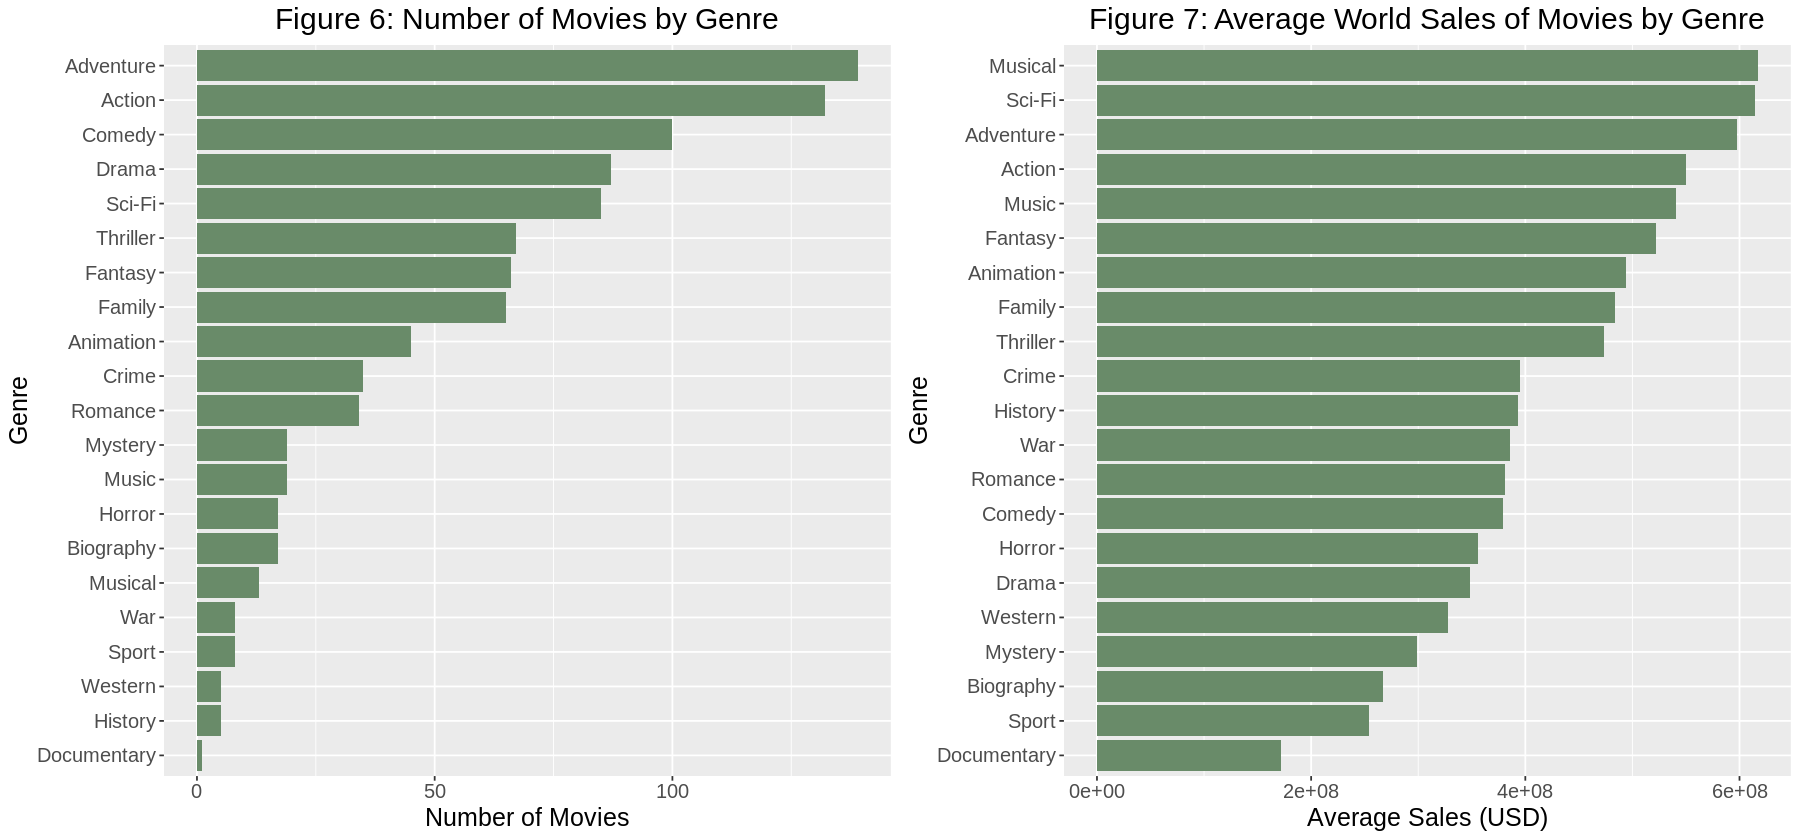

In [31]:
options(repr.plot.width = 15, repr.plot.height = 7)

grid.arrange(total_movies_by_genre_plot, avg_sales_by_genre_plot, ncol = 2) # plot 2 graphs side by side for comparison

Figure 6 was used to identify which genres were most representative of our dataset. Figure 7 was then used to visualize the relationship between genre and sales. In Figure 7, world sales are shown to vary according to genre. This indicated that genre could be a good predictor of movie success in our model.

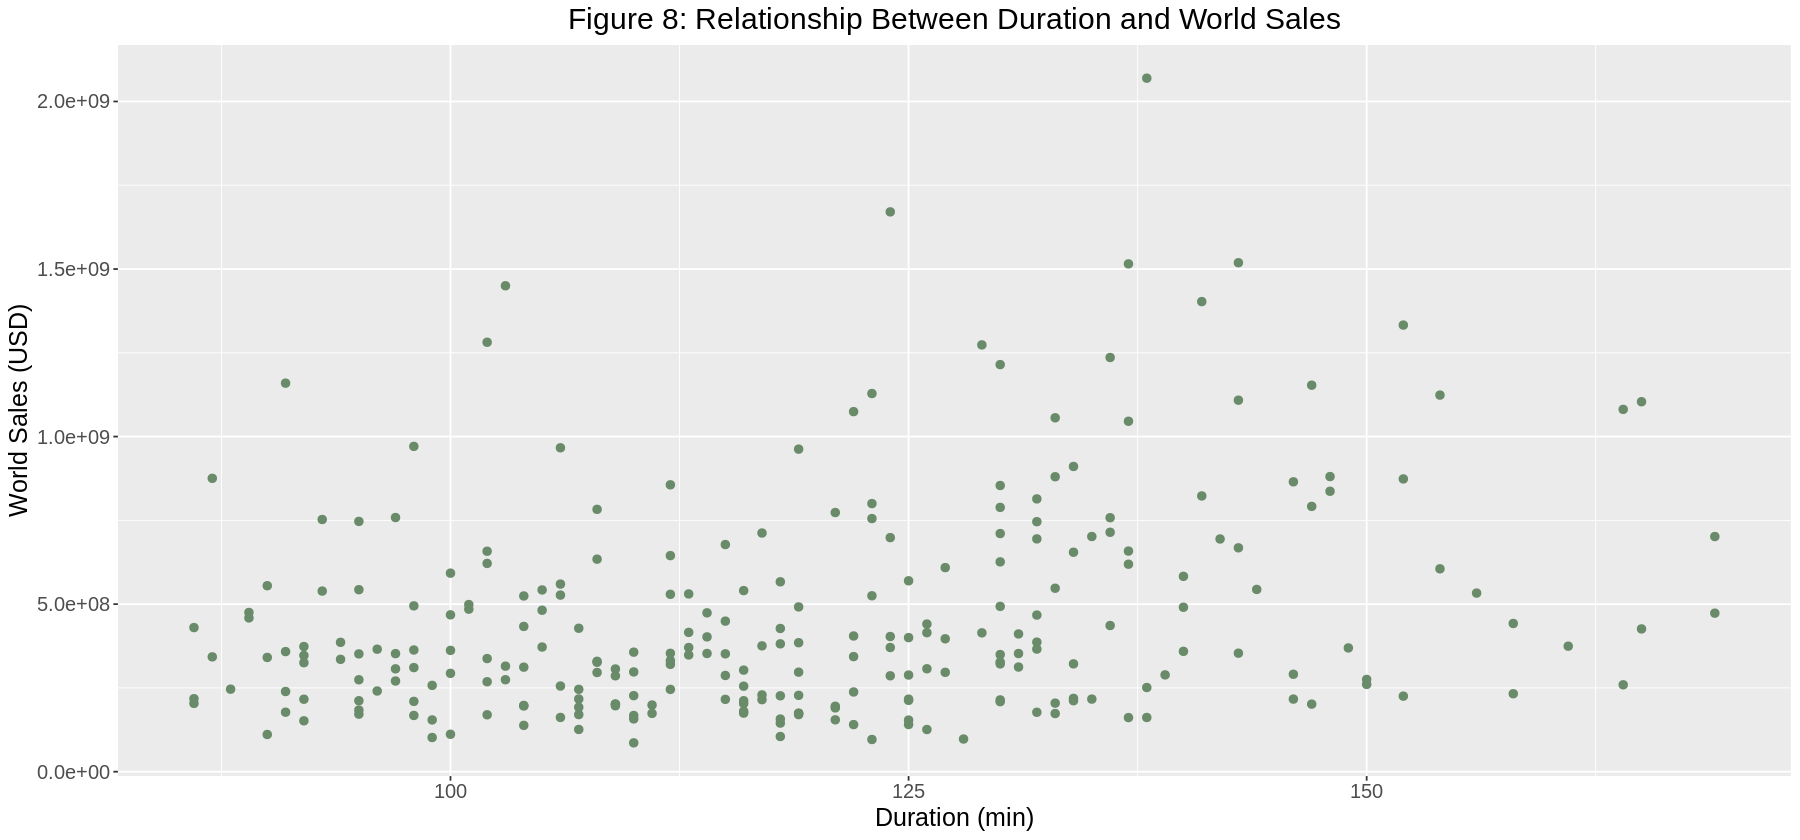

In [32]:
# plot the relationship between World Sales, Duration, and License
options(repr.plot.width = 15, repr.plot.height = 7)

duration_plot <- movies_train %>%
                    ggplot(aes(x = Duration, y = World_Sales)) +
                    geom_point(color = "darkseagreen4", size = 2) +
                    labs(x = "Duration (min)",
                         y = "World Sales (USD)") +
                    theme(text = element_text(size = 15),
                          plot.title = element_text(hjust = 0.5)) +
                    ggtitle("Figure 8: Relationship Between Duration and World Sales") 
                    
duration_plot

To examine the relationship between movie duration and world sales, we visualized the data using a scatter plot. In Figure 8, the data points are clustered around the range of 100 to 125 minutes, but there is no clear relationship observed. Therefore, we will consider both including and excluding duration as a predictor and determine the effect on model accuracy. 

## Regression Model

We chose to use multivariable regression since world sales is a continuous numerical variable and we wanted to use more than one predictor. We could not make any assumptions about the shape of the relationship between our predictors. With this in mind we chose to use knn regression over linear regression because of its flexibility with regards to the shape of the relationship. 

To be used in the regression model, each predictor needed to be numerical. To solve this we converted the license and distributor variables from class variables to numerical values. The license has a natural order (G, PG, PG-13, R). Therefore, we assigned each an integer label according to this order, thereby representing that some licenses are more similar than others. The distributors did not have a natural order, so we created dummy variables for each level to represent that each level is equally different. Since our distributors column was already of type factor, tidymodels did this for us automatically.

In [16]:
movies_train_num <- movies_train %>%
    mutate(License = as.numeric(License))
    
movies_test_num <- movies_test %>%
    mutate(License = as.numeric(License))

# movies_train
# glimpse(movies_train_num)
# movies_test
# movies_test_num

#### Model Using All Predictors

We then created our model specification and used a recipe to scale and center our data to ensure that each variable contributes equally when calculating distances between points. However, an error occurred whenever we tried to scale and center binary data (which included our genres and our dummy encoded distributors). As a result we decided to exclude these predictors from scaling and centering, seeing as these steps would not have a significant effect on binary variables.

We then chose the best k-value from a range of 1 to 100 using cross-validation to provide more certainty that we calculated an accurate indicator of model performance. Using the metrics from our cross validation, we visualized the RMSE values for each value of k (Figure 9) and picked the k value with the lowest RMSE to train our model. We tested the model by predicting the world sales for the movies in our testing set. We calculated both the RMSE for the training data and the RMSPE for the testing data to use as metrics to evaluate the performance of our model.


In [17]:
# perform cross validation

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

movies_recipe <- recipe(World_Sales ~ ., data = movies_train_num) %>%
    step_scale(License, Duration) %>%
    step_center(License, Duration)
    

movies_vfold <- vfold_cv(movies_train_num, v = 5, strata = World_Sales)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

movies_fit <- workflow() %>%
    add_recipe(movies_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = movies_vfold, grid = k_vals) %>%
    collect_metrics()

[1] "Best k: 7"


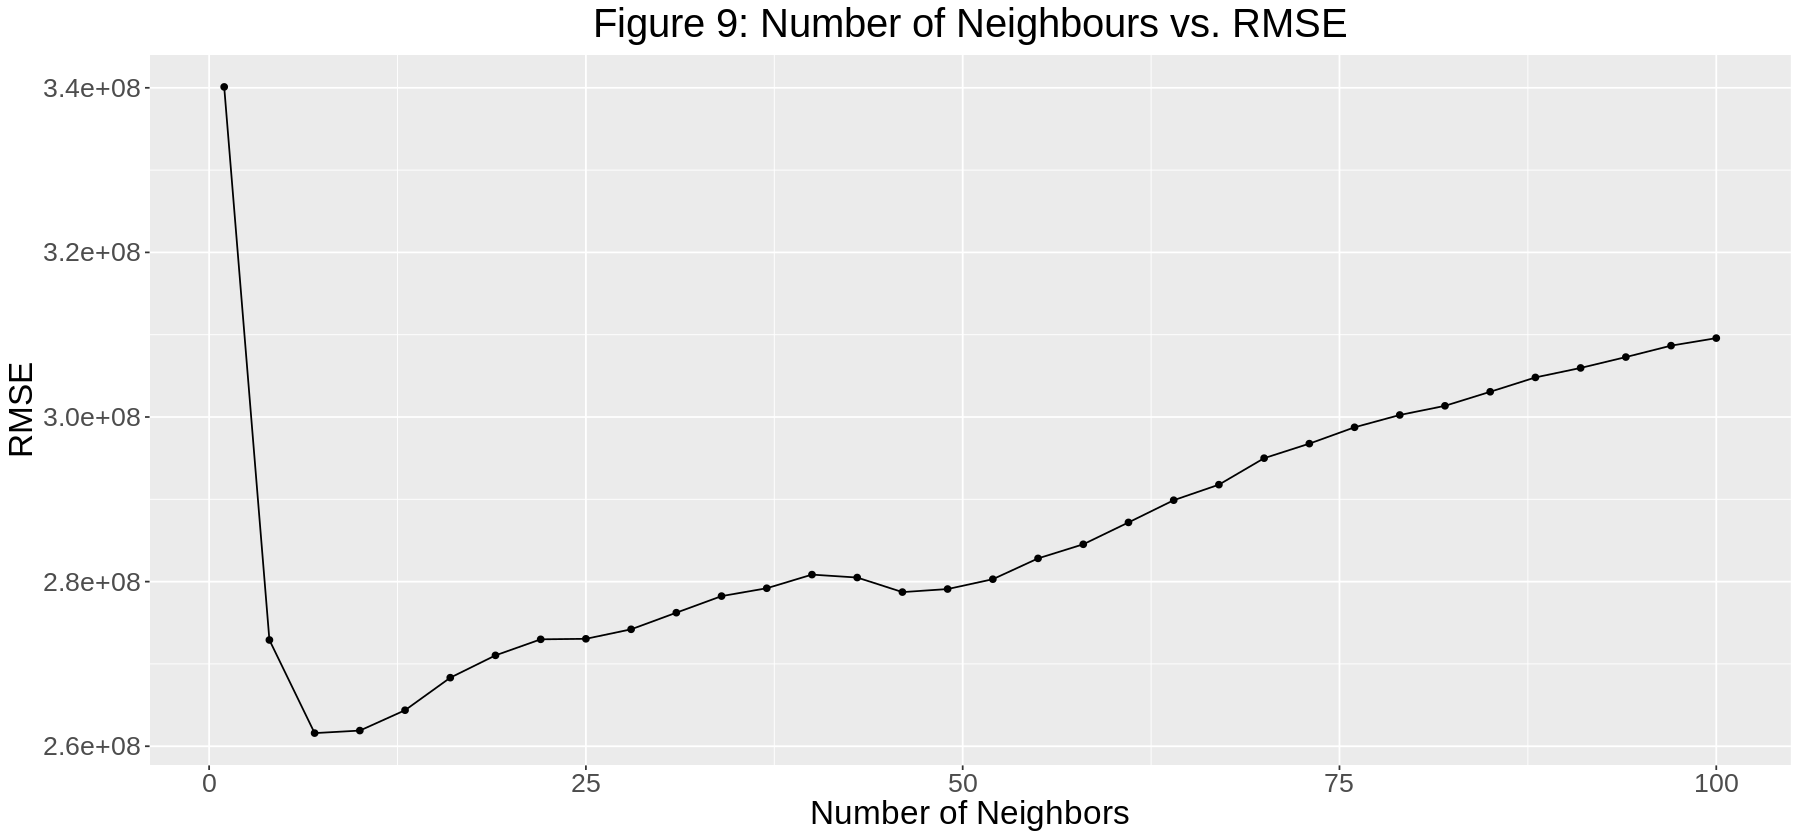

In [18]:
# determine best k

movies_cross_val_plot <- movies_fit %>%
    filter(.metric == "rmse") %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        xlab("Number of Neighbors") +
        ylab("RMSE") +
        theme(text = element_text(size = 20),   
              plot.title = element_text(hjust = 0.5)) +
        ggtitle("Figure 9: Number of Neighbours vs. RMSE")

best_k <- movies_fit %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1) %>%
    pull(neighbors)

movies_cross_val_plot 
print(paste("Best k:", as.character(best_k)))

In [19]:
# train and test regression model

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
    set_engine("kknn") %>%
    set_mode("regression")

movies_best_fit <- workflow() %>%
    add_recipe(movies_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(movies_train_num)

movies_rmse <- predict(movies_best_fit, movies_train_num) %>%
    bind_cols(movies_train_num) %>%
    metrics(truth = World_Sales, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    pull(.estimate)
print(paste("RMSE:", as.character(movies_rmse)))

movies_rmspe <- predict(movies_best_fit, movies_test_num) %>%
    bind_cols(movies_test_num) %>%
    metrics(truth = World_Sales, estimate = .pred) %>%
    filter(.metric == "rmse") %>%
    pull(.estimate)
print(paste("RMSPE:", as.character(movies_rmspe)))

[1] "RMSE: 231720658.749169"
[1] "RMSPE: 356892055.249929"


\
To determine whether duration should be used as a predictor, we ran the regression model once using all of our predictors and once excluding distribution. The RMSE and RMSPE values were significantly lower when we used all predictors, so we chose this as our final model (*Table 4*)

| Model                           | Best k | RMSE      | RMSPE     |
|---------------------------------|--------|-----------|-----------|
| Using All Predictors            | 7      | 231720658 | 356892055 |
| Excluding Duration as Predictor | 22     | 276899991 | 370145755 |


*Table 4*: Model Comparison

#### Visualization of model

Since we have 24 predictor variables, we decided to examine our model using multiple graphs. To determine how closely our predicted values represent the actual sales, we illustrated the predicted and actual sales values with a boxplot to examine the range, mean value, and outliers (Figure 10). Similarly, we compared how well the model predicted sales for each variable using a combination of bar chart (Figure 11 & Figure 12), box plot (Figure 13) and scatter plot (Figure 14). 

In [20]:
## define data frame for predicted and actual sales

movies_pred <- predict(movies_best_fit, movies_test_num) %>%
                     bind_cols(movies_test_num) 

In [21]:
# general visualization of results

# tidy the data
movies_pred_2 <- movies_pred %>%
                    pivot_longer(cols = c(.pred, World_Sales),
                                 names_to = "type",
                                 values_to = "sales")

movies_pred_plot <- movies_pred_2 %>%
                 ggplot(aes(x = type, 
                             y = sales,
                             fill = type)) +
                 geom_boxplot() +
                 theme(text = element_text(size = 30),
                       plot.title = element_text(hjust = 0.5),
                       legend.position = "none") +
                       ggtitle("Figure 10: Predicted vs Actual World Sales") +
                       ylab("World Sales (USD)") +
                       xlab("Type") +
                       scale_fill_manual(values = c("dodgerblue3", "darkseagreen")) +
                       scale_x_discrete(labels = c("Predicted", "Actual"))

In [22]:
# visualization for distributor and world sales
movies_distr <- movies_pred %>%
                    group_by(Distributor) %>%
                    summarize(mean_pred_sales = mean(.pred),
                              mean_world_sales = mean(World_Sales)) %>%
                    pivot_longer(cols = mean_pred_sales:mean_world_sales,
                                 names_to = "type",
                                 values_to = "sales")

movies_distr_plot <- ggplot(movies_distr, aes(x = reorder(Distributor, sales), 
                                                y = sales,
                                                fill = type)) + 
                            geom_bar(stat = "identity", position = "dodge", width = 0.7)  +
                            xlab("Distributor") +
                            ylab("Average World Sales (USD)") +
                            labs(fill = "Type") +
                            theme(text = element_text(size = 25),   
                                  plot.title = element_text(hjust = 0.5)) +
                            ggtitle("Figure 11: Average World Sales by Distributor") +
                            scale_fill_manual(values = c("dodgerblue3", "darkseagreen"),
                                         labels = c("Predicted", "Actual")) +
                            coord_flip()

`summarise()` ungrouping output (override with `.groups` argument)



In [23]:
## visualization for genre & world sales

# create subset with only World_Sales and Genre columns
pred_by_genre <- movies_pred %>%
                    select(Action:Documentary, World_Sales, .pred)%>% 
                    mutate(across(Action:Documentary, ~ .x * .pred, .names = "{.col}")) %>%  
                    select(-World_Sales, -.pred) %>%
                    bind_rows(purrr::map_dbl(.,sum)) %>%
                    select(Action:Documentary) %>%
                    tail(1) %>%
                    pivot_longer(cols = Action:Documentary,                                     
                                 names_to = "genre",
                                 values_to = "pred_sales")

# calculate mean predicted sales
avg_sales_by_genre_2 <- merge(avg_sales_by_genre, pred_by_genre) %>%
                            mutate(.pred_avg_sales = pred_sales/total_movies) %>%              # named the column .pred_avg_sales for consistent color scheme to other figures
                            select(genre, .pred_avg_sales, average_sales) %>%
                            pivot_longer(cols = .pred_avg_sales:average_sales,
                                 names_to = "type",
                                 values_to = "avg_sales")

avg_sales_by_genre_2_plot <- ggplot(avg_sales_by_genre_2 , aes(x = reorder(genre, avg_sales),  # sort by highest average actual sales
                                                               y = avg_sales,
                                                               fill = type)) + 
                                geom_bar(stat = "identity", position = "dodge", width = 0.7)  +
                                labs(fill = "Type",
                                     y = "Average World Sales (USD)",
                                     x = "Genre") +
                                theme(text = element_text(size = 25),   
                                      plot.title = element_text(hjust = 0.5)) +
                                ggtitle("Figure 12: Average World Sales by Genre") +
                                scale_fill_manual(values = c("dodgerblue3", "darkseagreen"),
                                         labels = c("Predicted", "Actual")) +
                                coord_flip()

In [24]:
## visualization for license and world_sales

license_plot <- movies_pred_2 %>%
                 ggplot( aes(x = reorder(License, sales), 
                             y = sales,
                             fill = type)) +
                 geom_boxplot() +
                 theme(text = element_text(size = 25),
                       plot.title = element_text(hjust = 0.5)) +
                       ggtitle("Figure 13: World Sales by License") +
                       ylab("World Sales (USD)") +
                       xlab("License") +
                       labs(fill = "Type") +
                       scale_fill_manual(values = c("dodgerblue3", "darkseagreen"),
                                         labels = c("Predicted", "Actual")) +
                       scale_x_discrete(labels = c("R", "PG-13","PG","G"))


In [25]:
## visualization for duration and world sales

duration_plot_2 <- movies_pred %>%
                    ggplot(aes(x = Duration, y = World_Sales)) +
                                            geom_point(color = "darkgreen") +
                                            geom_line(aes(y = .pred),
                                                      col = "dodgerblue3")  +
                                            xlab("Duration (min)") +
                                            ylab("World Sales (USD)") +
                                            theme(text = element_text(size = 25),   
                                                  plot.title = element_text(hjust = 0.5)) +
                                            ggtitle("Figure 14: Relationship Between Duration and World Sales") +
                                            scale_color_brewer(labels = c("Predicted", "Actual")) 


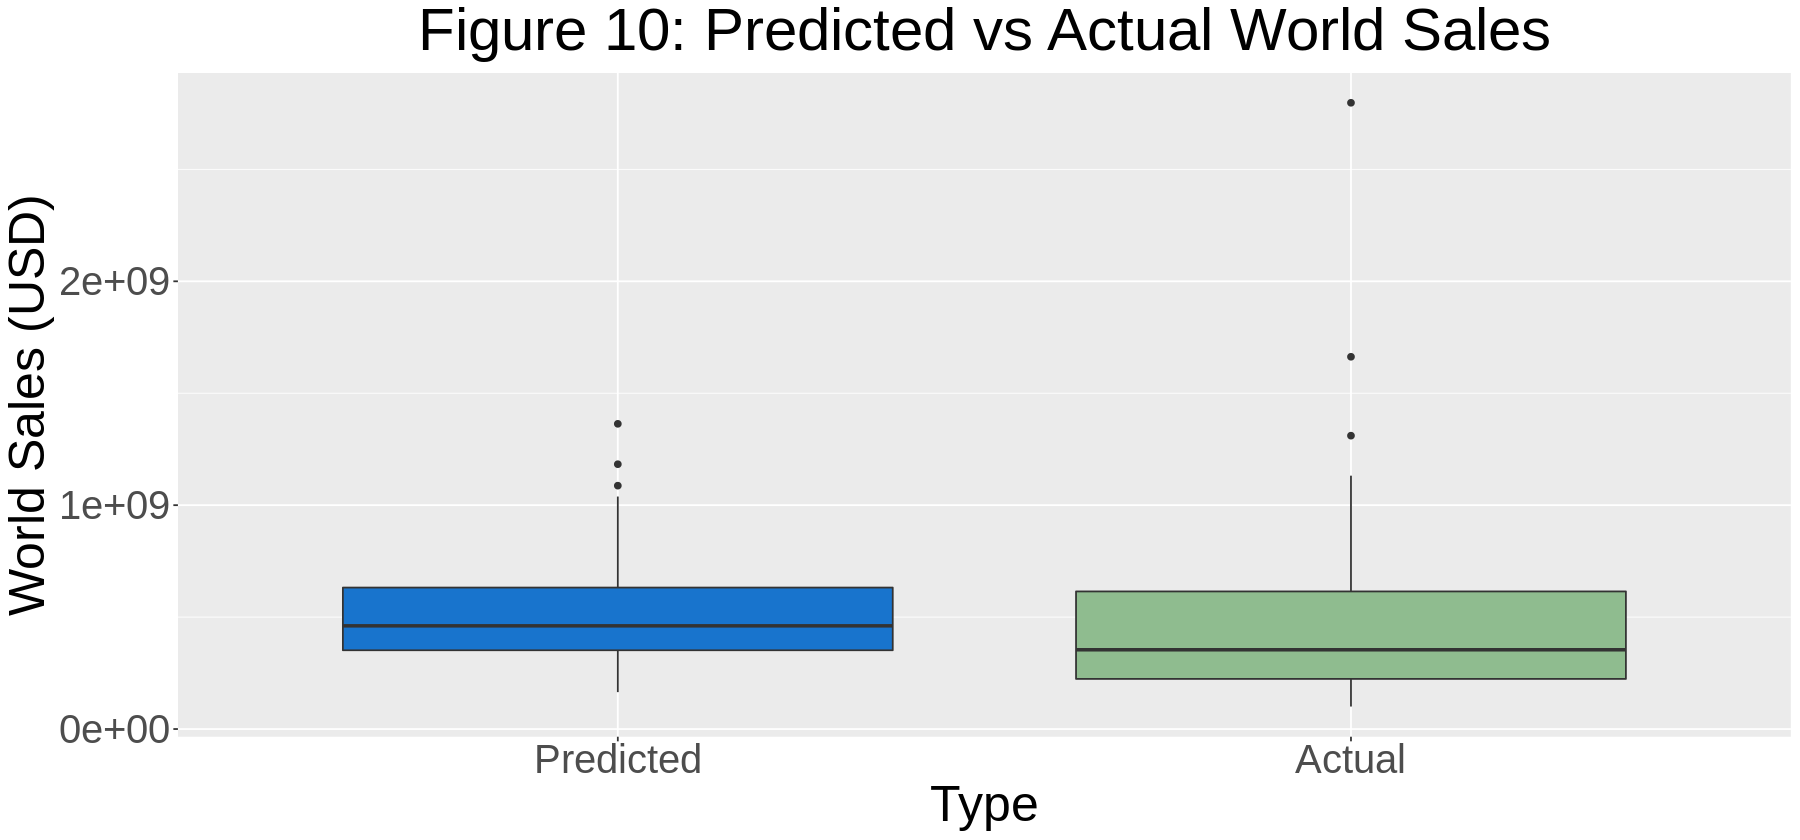

In [26]:
movies_pred_plot

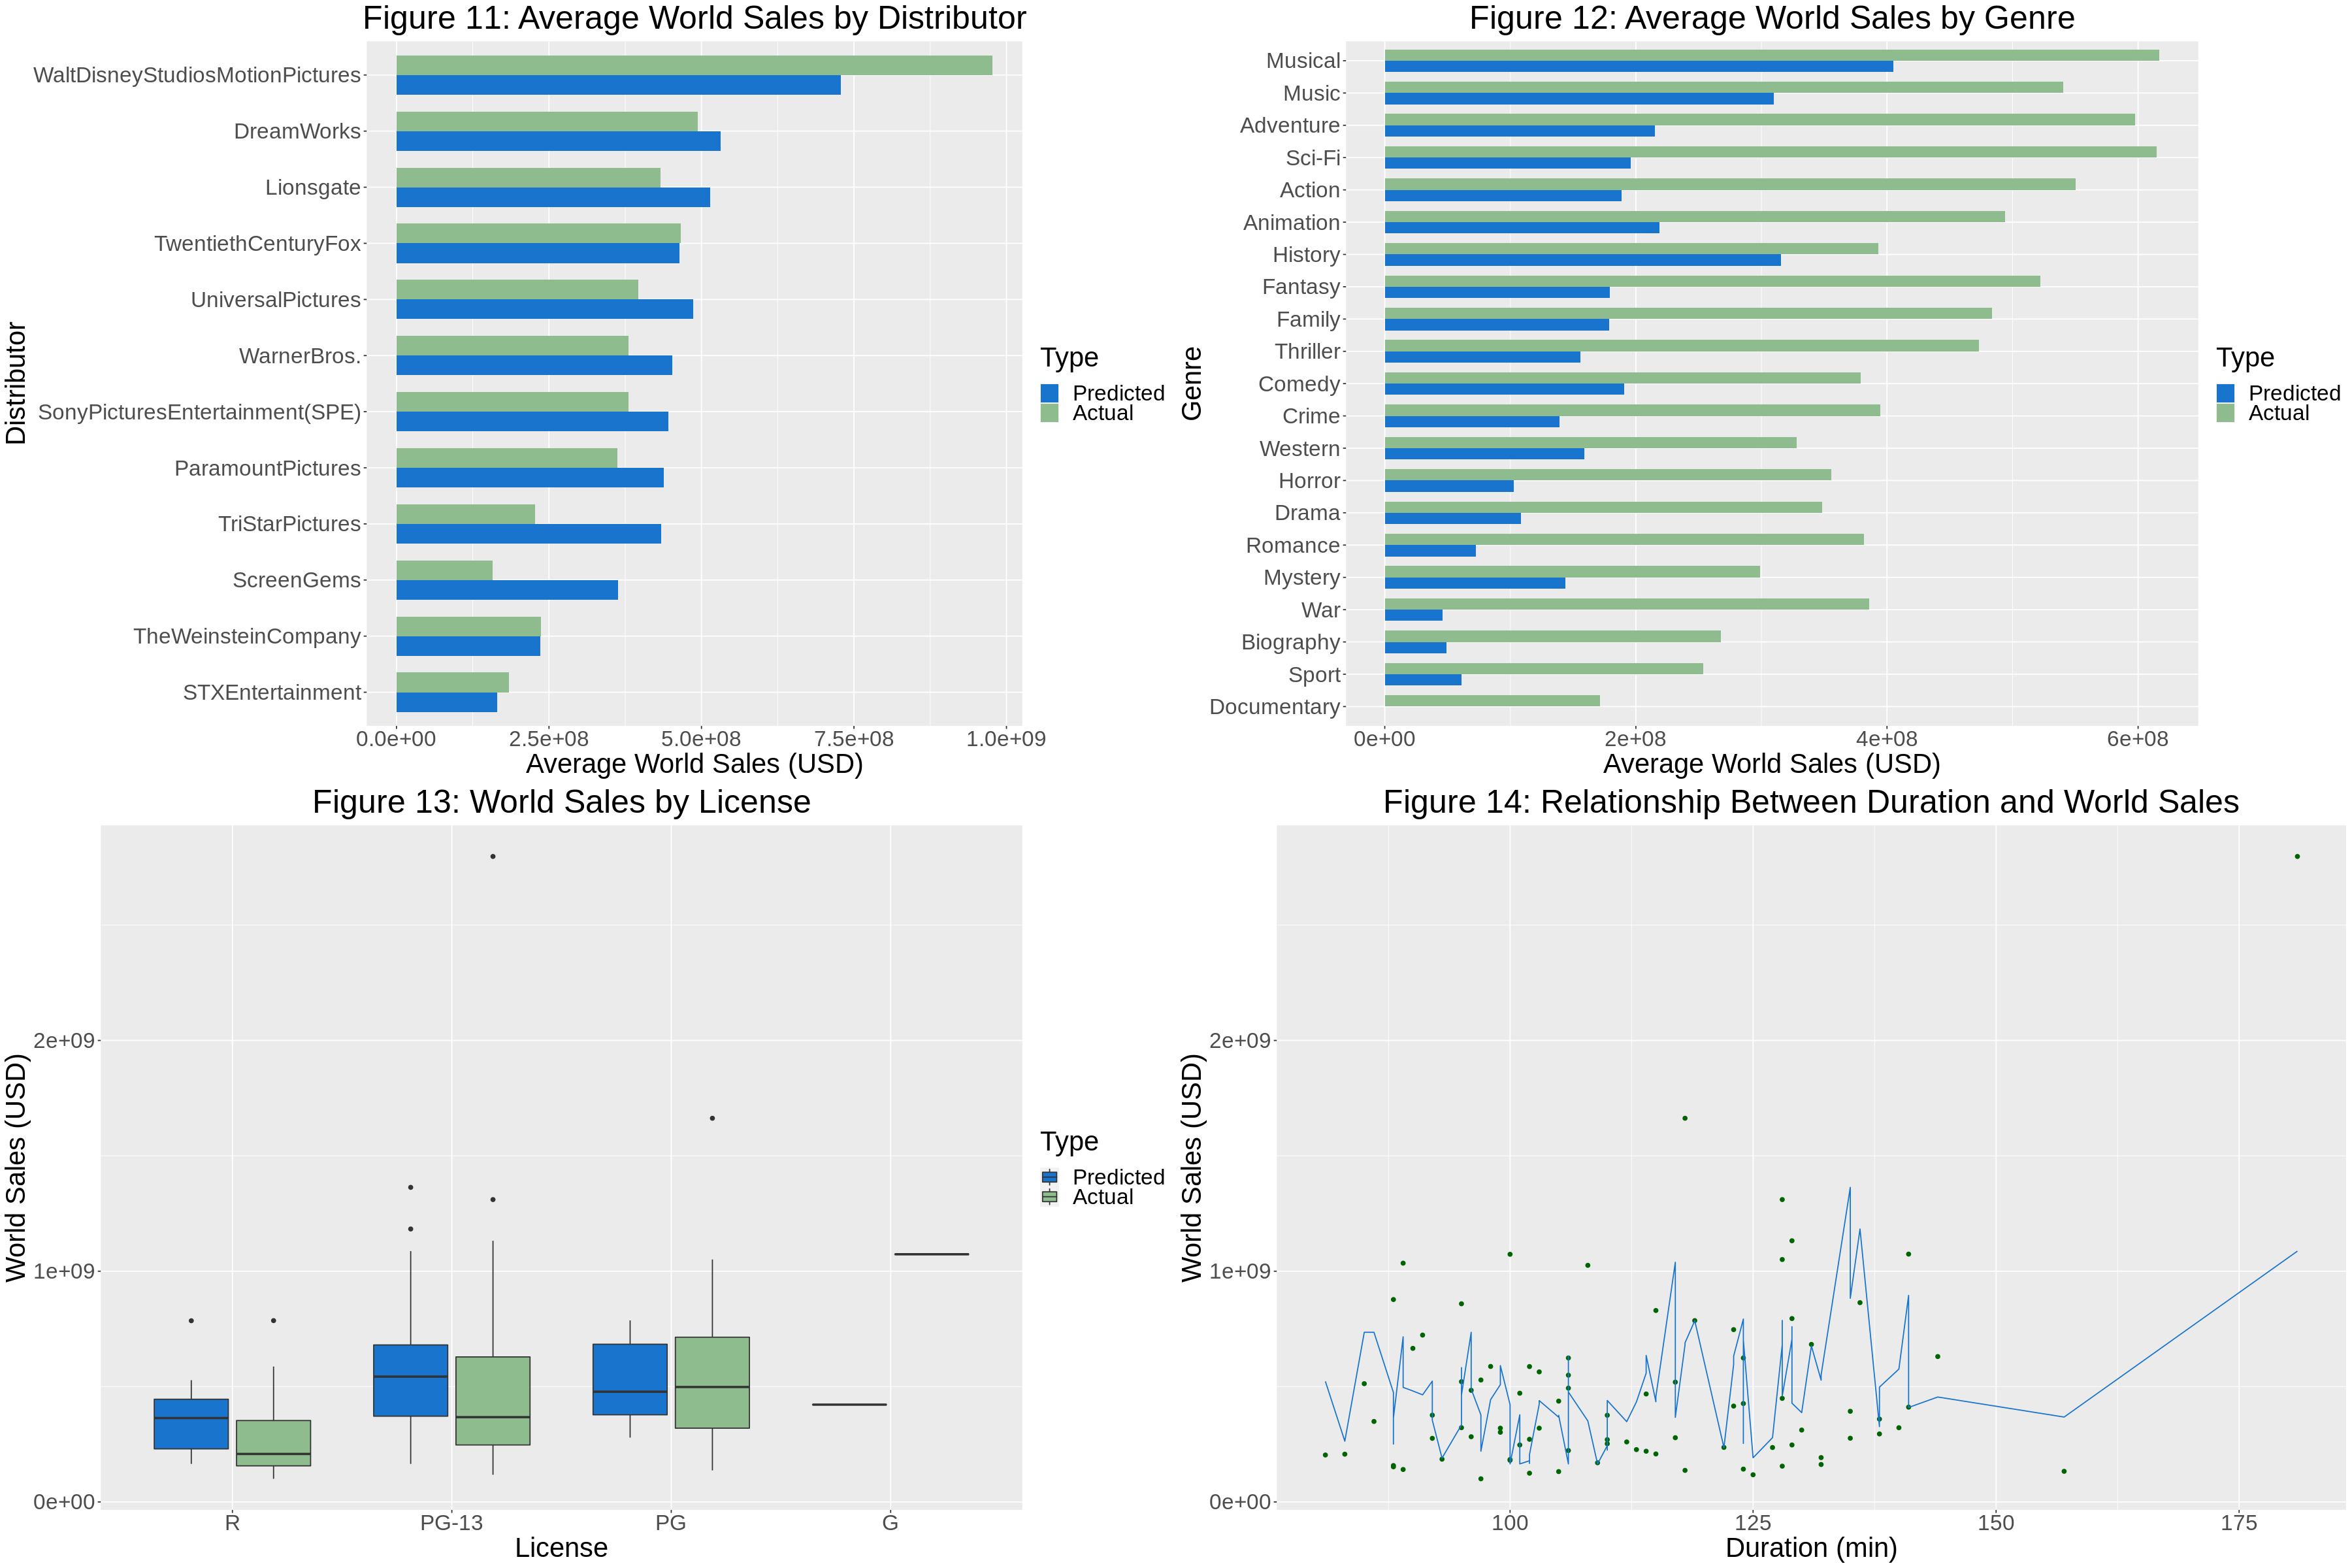

In [27]:
options(repr.plot.width = 30, repr.plot.height = 20)
grid.arrange(movies_distr_plot, avg_sales_by_genre_2_plot, license_plot, duration_plot_2, ncol = 2)

## Discussion

Using movie genre, duration, distributor, and license as predictors, we created a KNN regression model to predict the world movie sales. Our final model was able to predict the sales on new movies from our testing set. However, the model is not very precise or accurate. As shown in Figure 10, the average predicted sales are higher than the true values and the spread of data is narrower. This overprediction is also shown in Figure 11, as sales are overpredicted for most distributors. This is especially evident near the lower range of predictions. The RMSPE value for this model was 356892055, meaning that the predicted world sales will be overpredicted or underpredicted by on average $356,892,055. The RMSPE value is 77% percent of the average world sales, so this error is significant.

The model’s tendency to overpredict could be explained by several factors. A potential source of error could be that our categorical predictors were not balanced because some distributors, licenses or genres were present in higher frequencies than others. In future studies, a dataset containing a more balanced distribution could be chosen.

Our model was also potentially overfitting with regards to duration. This is indicated by the jagged line present in Figure 14. In the future, we could see if increasing k-value would result in a smoother prediction line and a better RMSPE value.
As shown in Figure 12, the regression was least accurate for genre and sales were underpredicted. This could be a result of separating and converting the variable into several binary columns. It is possible that the predicting power was reduced, and each genre variable was not considered as much as other variables. This could explain why these values are inaccurate. In future studies, this could potentially be resolved by adjusting the scaling of these variables.

Overall, the accuracy of our regression model was lower than we expected and some of the relationships between each predictor and world sales differed as well. We found that licenses accessible to a larger audience, such as PG and PG-13, were a predictor of higher sales (Figure 13). These results are consistent with previous findings, such as a study exploring cinematic success criteria that reported that R-rated films tend to have lower profits than PG-13 films (Simonton, 2009). On the other hand, this regression model did not find a clear relationship with duration and time (Figure 14). This contradicts the findings of previous studies that concluded that there is a positive correlation between runtime and movie success (Dhir & Raj, 2018).

To improve this model, future projects could consider using a dataset with a wider range of world sales. Since our dataset contains only the highest grossing movies, the predicted values are only accurate within this range. Therefore, having a more diverse dataset would help with the model accuracy outside of this range. The sources of error mentioned earlier, and their potential solutions should also be addressed in future studies.

Given the large error associated with our model, it could be useful for gaining a rough estimate of predicted sales. However, in situations that require a more precise prediction, such as budgeting, further refinement of this regression model would be necessary.



## References

Dhir, R. & Raj, A. (2018). Movie success prediction using machine learning algorithms and their comparison. Paper presented at the - 2018 First International Conference on Secure Cyber Computing and Communication (ICSCCC), 385-390. https://doi.org/10.1109/ICSCCC.2018.8703320

Galvão, M., & Henriques, R. (2018). Forecasting Movie Box Office Profitability. Journal of Information Systems Engineering and Management, 3(3), 22. https://doi.org/10.20897/jisem/2658

Naik, S. S. (2022). Top 1000 Highest Grossing Movies [Data file]. Retrieved from https://www.kaggle.com/datasets/sanjeetsinghnaik/top-1000-highest-grossing-movies?select=Highest+Holywood+Grossing+Movies.csv

Simonton, D. K. (2009). Cinematic success criteria and their predictors: The art and business of the film industry. Psychology & Marketing, 26(5), 400-420. 
https://doi.org/https://doi.org/10.1002/mar.20280